# **DLIP Tutorial - PyTorch**
# Transfer Learning using Pre-trained Models (Classification)

Y.-K. Kim
(updated 2024. 5. 9) 


- Part1: inference using pre-trained model

- **Part2: Transfer Learning using Pre-trained Models (Classification)**

The purpose of this tutorial is to learn how to **transfer learning** using a pre-trained model.




In this document we will perform two types of **transfer learning**: 
- **finetuning**: update all parameters of the pretrained model for our new task
- **feature extraction**: only update the final layer weights for predictions

## For CoLab Usage:

1. Download this notebook
2. Then, open in Colab

# Preparation

we will download Python modules and image data. 
- [download modules](https://github.com/ykkimhgu/DLIP-src/blob/main/Tutorial_Pytorch/2024/T3_2_pytorch_classification_modules.zip)
- [download dataset(ant/bee)](https://drive.google.com/file/d/123qUnqUpSzpnj7BnJjftFClmK6PLRzfA/view?usp=sharing)

![image](https://github.com/ykkimhgu/DLIP_doc/assets/38373000/7d28bace-6d4a-4845-ae1f-e821b82e0c90)


In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



### Import from the downloaded modules

In [37]:
# from set_parameter_requires_grad import set_parameter_requires_grad
from initialize_model import initialize_model
from my_train import train
from my_test import test

### GPU Setting

In [38]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")
if torch.cuda.is_available(): print(f'Device name: {torch.cuda.get_device_name(0)}') 

Using cuda device
Device name: NVIDIA GeForce RTX 4080 Laptop GPU


# Load Pretrained MODEL

Basically, the classification models provided by torchvision are trained on ImageNet and consist of 1000 output layers.

However, in the model for fine-tuning with other datasets, the number of output layers should be different depending on the class.

Here, we use the initialize_model() function provided in the [pytorch tutorial](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html) to change the output stage of the model.

initialize_model() is a function that helps to initialize the fine-tuning of some models.

If the model is not in the function, the output layer information can be known by printing the model with the print() function.

### Load Resnet with initialization_model()

In [39]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception*]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 2

# - True(feature extraction): only update the reshaped layer params,
# - False(finetuning)       : finetune the whole model, 
feature_extract = True  

model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
model_ft = model_ft.to(device)


summary(model_ft, (3,input_size,input_size))

print(model_ft)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

c:\Users\Sangheon\anaconda3\envs\py39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sangheon\anaconda3\envs\py39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Prepare Datasets: hymenoptera_data

The downloaded datafile `hymenoptera_data.zip` should be in the subfolder `\data`

Unzip hymenoptera_data.zip to create training data

[hymenoptera_data](https://www.kaggle.com/datasets/ajayrana/hymenoptera-data) is a binary (Ants and Bees) classification dataset consisting of a small number of images.

In [40]:
import shutil
import os
shutil.unpack_archive("data/hymenoptera_data.zip", "data")

The images in the prepared dataset have different sizes. In order to be used as a learning model, the following process is required.

- Assign the images in the folder to training/test data for learning
- Same pre-processing as ImageNet data for input of learning model
- Resize the new dataset to the input size of pretrained model (e.g. 224 x 224)

In [41]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = "./data/hymenoptera_data"

# Data augmentation and normalization for training
# Just normalization for validation
# Normalized with ImageNet mean and variance
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

training_data = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform['train'])
test_data = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform['val'])

classes = ['ant', 'bee']
print(f"train dataset length = {len(training_data)}")
print(f"test  dataset length = {len(test_data)}")

Initializing Datasets and Dataloaders...
train dataset length = 244
test  dataset length = 153


Use DataLoader to make dataset iterable.

In [42]:
# Batch size for training (change depending on how much memory you have)
batch_size = 8

train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape} {y.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([8, 3, 224, 224]) torch.int64
Shape of y: torch.Size([8]) torch.int64


# Optimization Setup

### Optmizer function 
 Gradient descent is the common optimisation strategy used in neural networks. Many of the variants and advanced optimisation functions now are available, 
  
- Stochastic Gradient Descent, Adagrade, Adam, etc

### Loss function

- Linear regression: Mean Squared Error
- Classification: Cross entropy

In [43]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft.parameters(), lr = 0.001, momentum=0.9,weight_decay=5e-4)

# Transfer Learning with New Dataset

In [48]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_ft, loss_fn, optimizer, device, 15)
    test(test_dataloader, model_ft, loss_fn, device)
print("Done!")

Epoch 1
-------------------------------
loss: 0.370493  [    0/  244]
loss: 0.396386  [  120/  244]
loss: 1.651856  [  240/  244]
Test Error: 
 Accuracy: 92.2%, Avg loss: 0.211043 

Epoch 2
-------------------------------
loss: 0.250571  [    0/  244]
loss: 0.098563  [  120/  244]
loss: 0.292612  [  240/  244]
Test Error: 
 Accuracy: 90.8%, Avg loss: 0.240363 

Epoch 3
-------------------------------
loss: 0.138716  [    0/  244]
loss: 0.328695  [  120/  244]
loss: 0.419735  [  240/  244]
Test Error: 
 Accuracy: 92.2%, Avg loss: 0.229874 

Epoch 4
-------------------------------
loss: 0.147260  [    0/  244]
loss: 0.402332  [  120/  244]
loss: 0.435232  [  240/  244]
Test Error: 
 Accuracy: 93.5%, Avg loss: 0.193770 

Epoch 5
-------------------------------
loss: 0.264490  [    0/  244]
loss: 0.133145  [  120/  244]
loss: 0.066497  [  240/  244]
Test Error: 
 Accuracy: 94.1%, Avg loss: 0.188379 

Epoch 6
-------------------------------
loss: 0.864477  [    0/  244]
loss: 0.096613  [  1

# Visualize test results

Select random test images and evaluate

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.019607842..1.0239352].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.018410504..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0046051443..1.043456].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.018410504..1.0083187].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.014574587..1.0395517].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.027450979..1.0473601].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0046

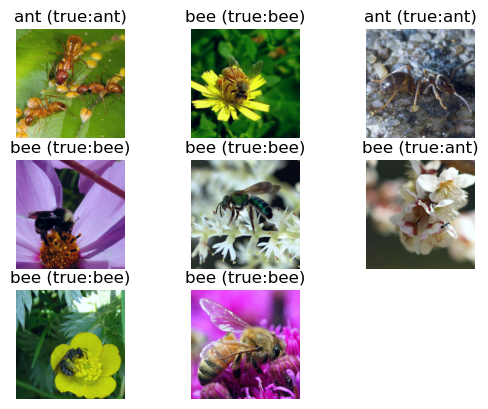

In [49]:
# Get some random test  images // BatchSize at a time
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
    pred = model_ft(images)
    _, predicted = torch.max(pred.data, 1);

figure = plt.figure()
num_of_images = min(batch_size, 9)

for index in range(num_of_images):
    plt.subplot(3, 3, index+1)
    plt.axis('off')    
    plt.title(f"Ground Truth: {classes[labels[index]]}")
    plt.title(f"{classes[predicted[index].item()]} (true:{classes[labels[index]]})")
    plt.imshow(np.transpose((images[index] * 0.224  + 0.456).cpu().numpy().squeeze(), (1, 2, 0)))  # 출력을 위한 차원변환 (channels*rows*cols) -> (rows*cols*channels)

Plot heatmap (confusion matrix)

     ant  bee
ant   68    2
bee    8   75


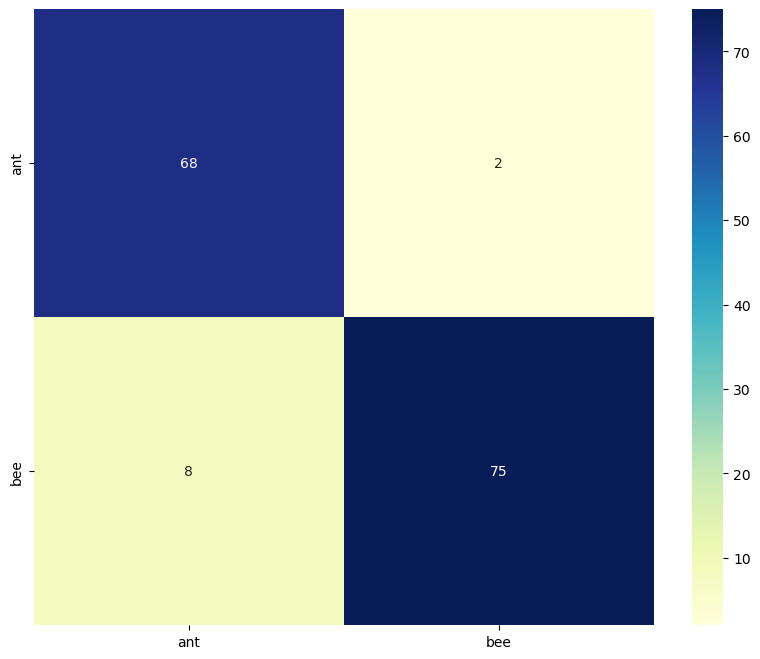

In [46]:
# Get some random test  images // BatchSize at a time
heatmap = pd.DataFrame(data=0,index=classes,columns=classes)

for images, labels in test_dataloader:
    with torch.no_grad():
        images, labels = images.to(device), labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            true_label = labels[i].item()
            predicted_label = predicted[i].item()
            heatmap.iloc[true_label, predicted_label] += 1
print(heatmap)
_, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(heatmap, annot=True, fmt="d", cmap="YlGnBu")
plt.show()

# Saving Models
* save the structure of this class together with the model

In [50]:
torch.save(model_ft, f"./models/{model_name}_ft(hymenoptera).pth")